#### Downloading & Inspecting EUMETSAT/MSG Data

Code adapted from https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/pages/1760198661/Python+Library

Requires signing up for an account with EUMETSAT EO Portal: https://eoportal.eumetsat.int/userMgmt/
Once done, the consumer key and secret can be found under the user information: https://eumetsatspace.atlassian.net/wiki/spaces/DSEV/pages/375652353/API+Authentication

In [1]:
import autoroot

In [79]:
import os
import ast
import eumdac
import datetime
import shutil
import pyproj
import rioxarray
import rasterio
import xarray as xr

from pyproj import CRS

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Insert your personal key and secret into the single quotes
consumer_key = ""
consumer_secret = ""

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

In [ ]:
datastore = eumdac.DataStore(token)
datastore.collections

In [ ]:
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')
selected_collection?

##### Define download parameters & compile list of products

In [ ]:
# Add vertices for polygon, wrapping back to the start point.
geometry = [[-1.0, -1.0],[4.0, -4.0],[8.0, -2.0],[9.0, 2.0],[6.0, 4.0],[1.0, 5.0],[-1.0, -1.0]]

# Set sensing start and end time
start = datetime.datetime(2021, 10, 10, 9, 0)
end = datetime.datetime(2021, 10, 10, 10, 0)

# Retrieve datasets that match our filter
products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in geometry])),
    dtstart=start, 
    dtend=end)
    
print(f'Found Datasets: {len(products)} datasets for the given time range')

for product in products:
    print(str(product))

##### Download products

Each product contains three files (EOPMetadata.xml, manifest.xml, and data.nat files). When downloading the whole product, a .zip folder is created.

In [ ]:
for product in products:
    with product.open() as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {product} finished.')
print('All downloads are finished.')

In [24]:
for product in products:    
    print(product.url)

https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMSG%3AHRSEVIRI/products/MSG4-SEVI-MSG15-0100-NA-20211010095743.941000000Z-NA?access_token=b86efc5f-3691-3821-99c6-f7f8a6dc98d5
https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMSG%3AHRSEVIRI/products/MSG4-SEVI-MSG15-0100-NA-20211010094243.725000000Z-NA?access_token=b86efc5f-3691-3821-99c6-f7f8a6dc98d5
https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMSG%3AHRSEVIRI/products/MSG4-SEVI-MSG15-0100-NA-20211010092743.511000000Z-NA?access_token=b86efc5f-3691-3821-99c6-f7f8a6dc98d5
https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMSG%3AHRSEVIRI/products/MSG4-SEVI-MSG15-0100-NA-20211010091243.299000000Z-NA?access_token=b86efc5f-3691-3821-99c6-f7f8a6dc98d5


##### Download only selected products & files

In [25]:
selected_product = datastore.get_product(
    product_id='MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA',
    collection_id='EO:EUM:DAT:MSG:HRSEVIRI')

The data is stored in a .nat file

In [26]:
for entry in selected_product.entries:
    print(entry)

EOPMetadata.xml
MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat
manifest.xml


In [11]:
try:
    with selected_product.open(entry='MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat') as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
except eumdac.product.ProductError as error:
    print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")

Download of file MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat finished.


In [27]:
try:
    with selected_product.open(entry='EOPMetadata.xml') as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
except eumdac.product.ProductError as error:
    print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")

Download of file EOPMetadata.xml finished.


Unfortunately, .nat files are a bit complicated to read/load. One of the best packages is satpy, which then allows loading the files using xarray.

In [4]:
from satpy import Scene
scn = Scene(reader="seviri_l1b_native", filenames=['MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat'])

In [131]:
# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
datasets

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

In order to convert the scn object to xarray, each dataset needs to be loaded.

In [132]:
scn.load(datasets[1:], generate=False)
# Note: The HRV channel comes in 1 km resolution, while the other channels are 3 km resolution.
# Because of the size mismatch, the HRV channel would either need to be downscaled,
# or it needs to the loaded separetely to the other channels


In [133]:
ds = scn.to_xarray()

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


In [134]:
# The x and y coordinate contain spatial information in meters
ds.y

<xarray.DataArray 'y' (y: 3712)>
array([-5565747.872591, -5562747.469425, -5559747.066259, ...,  5562747.469425,
        5565747.872591,  5568748.275757])
Coordinates: (12/13)
    IR_016_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
    spatial_ref      int64 0
    IR_039_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_087_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_097_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    ...               ...
    IR_120_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_134_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  projection_y_coordinate
    units:          m

In [136]:
ds.latitude.values

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [ ]:
# That's why we need to extract the satellite position, to convert the x and y coordinates to lat/lon
pa = ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])['projection_altitude']
saa = ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])['satellite_actual_altitude']

ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])

{'projection_longitude': 0.0,
 'projection_latitude': 0.0,
 'projection_altitude': 35785831.0,
 'satellite_nominal_longitude': 0.0,
 'satellite_nominal_latitude': 0.0,
 'satellite_actual_longitude': -0.3394201003380397,
 'satellite_actual_latitude': 0.3537999733591259,
 'satellite_actual_altitude': 35783787.81506324}

In [137]:
# Testing for one channel
dataset = scn['IR_016']

dataset.attrs

{'orbital_parameters': {'projection_longitude': 0.0,
  'projection_latitude': 0.0,
  'projection_altitude': 35785831.0,
  'satellite_nominal_longitude': 0.0,
  'satellite_nominal_latitude': 0.0,
  'satellite_actual_longitude': -0.3394201003380397,
  'satellite_actual_latitude': 0.3537999733591259,
  'satellite_actual_altitude': 35783787.81506324},
 'sun_earth_distance_correction_applied': True,
 'sun_earth_distance_correction_factor': 0.9901881739103313,
 'units': '%',
 'wavelength': WavelengthRange(min=1.5, central=1.64, max=1.78, unit='µm'),
 'standard_name': 'toa_bidirectional_reflectance',
 'platform_name': 'Meteosat-11',
 'sensor': 'seviri',
 'georef_offset_corrected': True,
 'time_parameters': {'nominal_start_time': datetime.datetime(2021, 11, 10, 8, 0),
  'nominal_end_time': datetime.datetime(2021, 11, 10, 8, 15),
  'observation_start_time': datetime.datetime(2021, 11, 10, 8, 0, 10, 65000),
  'observation_end_time': datetime.datetime(2021, 11, 10, 8, 12, 42, 766000)},
 'start_ti

In [139]:
dataset.latitude

<xarray.DataArray 'latitude' (x: 3712)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    crs          object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknow...
  * x            (x) float64 5.566e+06 5.563e+06 ... -5.566e+06 -5.569e+06
    spatial_ref  int64 0
    latitude     (x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [140]:
crs_wkt = dataset.attrs['area'].crs_wkt

# Define the source CRS from the WKT string
source_crs = pyproj.CRS(crs_wkt)
target_crs = 'EPSG:4326' # Global lat-lon coordinate system

In [141]:
# copy dataset
new_dataset = dataset.copy(deep=True)

# assign CRS to dataarray
new_dataset = new_dataset.rio.write_crs(source_crs, inplace=False)

In [144]:
print(new_dataset.dims)
print(new_dataset.coords)
# Drop acq_time coordinate, which was causing issues
# new_dataset = new_dataset.drop('acq_time') 
new_dataset = new_dataset.drop('latitude') # NOTE: Not sure why this is necessary?
new_dataset = new_dataset.drop('longitude') # NOTE: Not sure why this is necessary?
# Reproject the data to the target CRS
new_dataset = new_dataset.rio.reproject(target_crs)

('y', 'x')
Coordinates:
    crs          object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknow...
  * y            (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x            (x) float64 5.566e+06 5.563e+06 ... -5.566e+06 -5.569e+06
    latitude     (x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    longitude    (y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    spatial_ref  int64 0


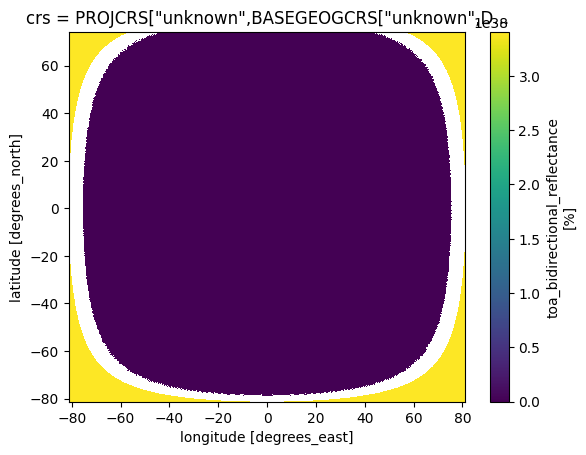

In [145]:
new_dataset.plot()
# Something strange is happening to the data? All values are set to XE38, which is not correct.

In [107]:
# Assign latitude/longitude coordinates to original data
dataset['latitude'] = new_dataset.x
dataset['longitude'] = new_dataset.y

TODO:

- Finish reprojection function. Currently a few problems: 
    - pyproj modifies the data
    - the shape of the new x/y is not the same as before